<a href="https://colab.research.google.com/github/kvame96/NOVIA/blob/main/%22Dynamical%20Systems%22_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP DATA

Collected data

Mounted at /content/drive


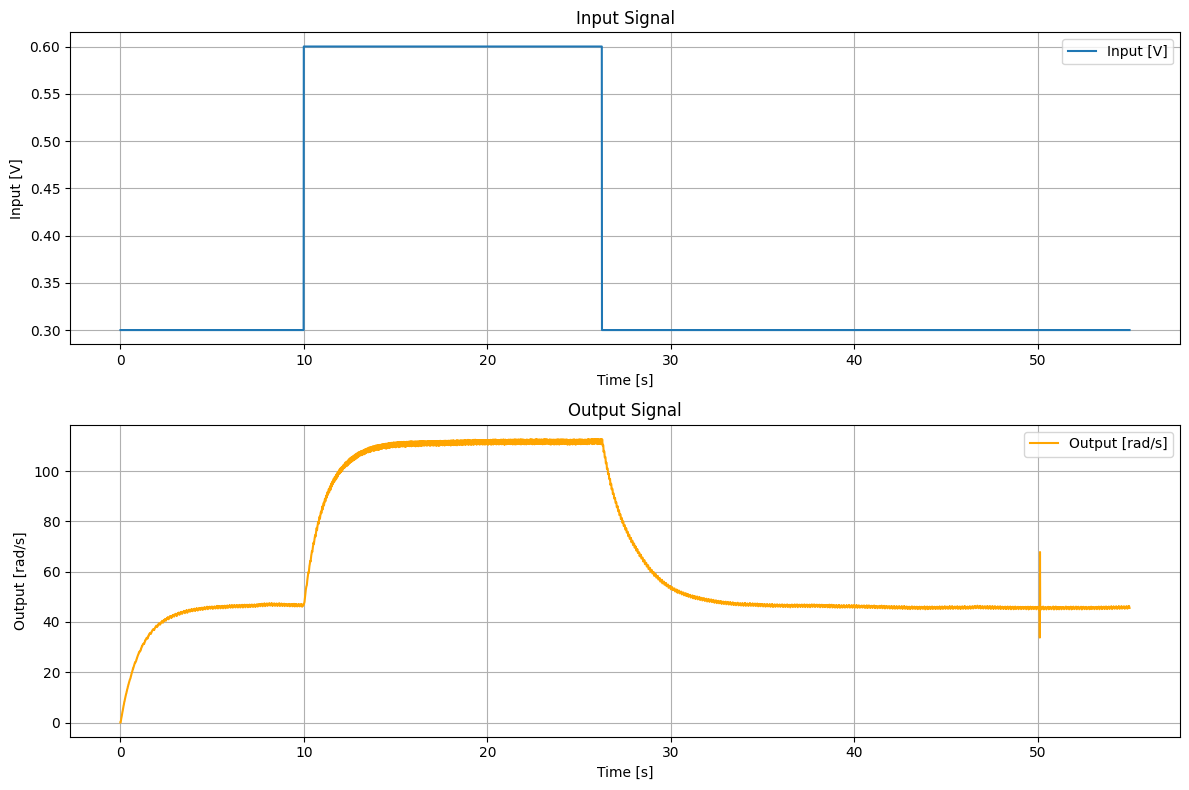

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import TransferFunction, lti, step, bode, lsim

# Load step response data
from google.colab import drive
drive.mount('/content/drive')
import os
google_drive_root = '/content/drive/MyDrive'
assignment2_loc = '/Novia/Dynamical Systems/Datamaterial for assignment 2-20241124'
os.chdir(google_drive_root + assignment2_loc)
csv_file_name = 'StepData.csv'
step_data = pd.read_csv(csv_file_name)

time_step = step_data.iloc[:, 0]         # time vector computed in seconds [s]
input_signal = step_data.iloc[:, 1]      # Input vector in Volts [V]
output_signal = step_data.iloc[:, 2]     # Output vector in meters per seconds [rad/s]

# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot
plt.plot(time_step, input_signal, label="Input [V]")
plt.title('Input Signal')
plt.xlabel('Time [s]')
plt.ylabel('Input [V]')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot
plt.plot(time_step, output_signal, label="Output [rad/s]", color='orange')
plt.title('Output Signal')
plt.xlabel('Time [s]')
plt.ylabel('Output [rad/s]')
plt.legend()
plt.grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

Cross-correlation function to estimate the lag, if any.

Estimated time lag between input and output signals: 0.6800 seconds


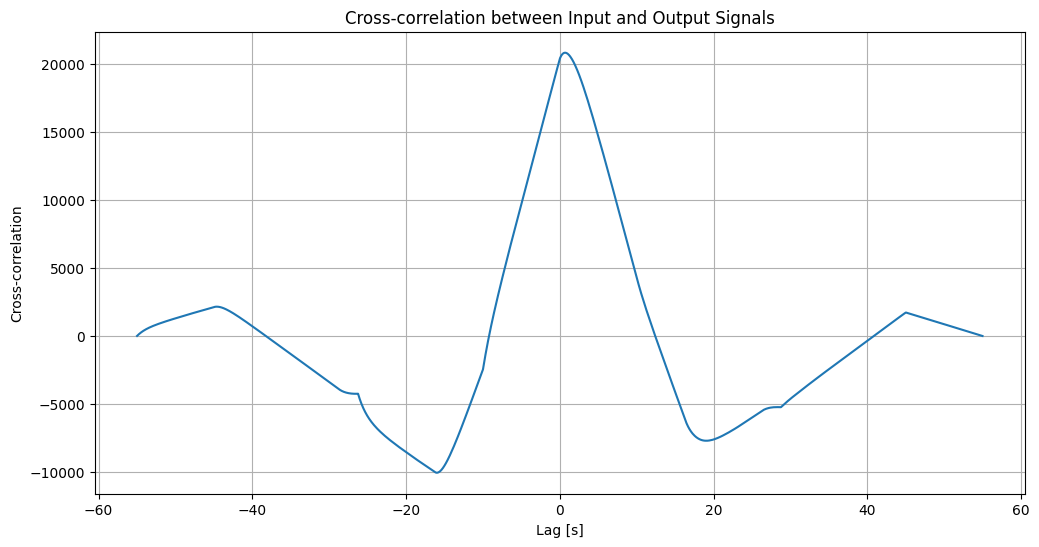

In [2]:
from scipy.signal import correlate
from scipy.signal.windows import parzen

# Detrend the signals by subtracting the mean to remove the DC component
input_detrended = input_signal - input_signal.mean()
output_detrended = output_signal - output_signal.mean()

# Calculate the cross-correlation
# We use 'full' mode to get all possible lags
cross_corr = correlate(output_detrended, input_detrended, mode='full')

# The lag can be determined from the index of the peak of the cross-correlation
# The lags array corresponds to the cross_corr result
lags = np.arange(-output_detrended.size + 1, input_detrended.size)

# Find the index of the maximum cross-correlation
delay_arr = lags[np.argmax(cross_corr)]

# Convert the index delay to time lag
# time_step is the time vector, assuming uniform sampling
time_lag = delay_arr * (time_step[1] - time_step[0])

print(f"Estimated time lag between input and output signals: {time_lag:.4f} seconds")

# Optional: Plot cross-correlation to visualize
plt.figure(figsize=(12, 6))
plt.plot(lags * (time_step[1] - time_step[0]), cross_corr)
plt.title('Cross-correlation between Input and Output Signals')
plt.xlabel('Lag [s]')
plt.ylabel('Cross-correlation')
plt.grid(True)
plt.show()

## First Order transfer function Plus Dead Time (FOPDT)
We will proceed defining the transfer function of the system, after having cleared the signal from the noise in the third transient (elements 5012 & 5013 of "StepData.csv").

Let's assume the following statements for the system:
- first order (reasonable assumption since it seems to have no inflexion point)
- Lag mentioned before

Transfer function:
$$
G(s) = \frac{K}{\tau s + 1} e^{-L s}
$$
\
Now:
- Let's get rid of the noise at the second 50.10 & 50.11 changing those values with the closest ones (50.09 & 50.12).
- Let's compute the static gain as the rate output / input between the end of the first transient and the end of the second transient (points just before the 26.24th second and the 10th, respectively).\
To have more reliable values, the computation of output / input was performed in the interval 9.5-10 sec & 25.74-26.24 sec.\
Tau is the insatnt of time when the response reached 63.2% of the steady state value.
- Let's simulate the system with "lsim".


In [3]:
## Identify transfer function from step response
## Assuming first-order system: G(s) = K / (T*s + 1)

# The signal contains some noise in the first transient. Let's clean it.
output_signal[5010] = output_signal[5009]
output_signal[5011] = output_signal[5012]

################################################################################

# Mean value of the input & output from seconds 9.5 to 10 and from second 25.74 to 26.24
mean_initial_input = input_signal.iloc[947:997].values
mean_initial_output = output_signal.iloc[947:997].values
mean_final_input = input_signal.iloc[2572:2622].values
mean_final_output = output_signal.iloc[2572:2622].values

# Calculate the mean value
mean_initial_input = mean_initial_input.mean()
#print("Mean value of the initial input:", mean_initial_input)         # for debugging
mean_initial_output = mean_initial_output.mean()
#print("Mean value of the initial output:", mean_initial_output)       # for debugging
mean_final_input = mean_final_input.mean()
#print("Mean value of the final input:", mean_final_input)             # for debugging
mean_final_output = mean_final_output.mean()
#print("Mean value of the final output:", mean_final_output)           # for debugging

# Static gain K
delta_in  = mean_final_input - mean_initial_input
delta_out = mean_final_output - mean_initial_output
K = delta_out / delta_in
K_formatted = "{:.3f}".format(K)
print(f"Estimated static gain (K): {K_formatted}")

# Time constant tau
tau_delta_value  = 0.632 * delta_out                              # 63.2% of delta out value
tau_actual_value = mean_initial_output + tau_delta_value          # This is the actual value when it's at 63.2%
tau_idx = np.where(output_signal >= tau_actual_value)[0][0]       # The index in the array when output has reached 63.2%
tau = time_step[tau_idx]                                          # Use the index to get the corresponding time
step_up_in_idx = np.where(input_signal >= 0.45)[0][0]             # Let's find the index when the step up in the input signal happens (out-signal 0.3 -> 0.6 V)
# print(step_up_in_idx)                                           # for debugging
tau = tau - (step_up_in_idx/100)                                  # Remove the time before the increase to get accurate value for tau
tau_formatted = "{:.3f}".format(tau)
print(f"Estimated time constant (τ): {tau_formatted} seconds")

# Theoretical transfer function for lsim
numerator = [K]
denominator = [tau, 1]
system1 = TransferFunction(numerator, denominator)

################################################################################

# Generate time points
t = np.linspace(0, 55, 5500)

# Calculate the system's output using lsim (for custom input)
t, output_sim, _ = lsim(system1, input_signal, t)

Estimated static gain (K): 217.381
Estimated time constant (τ): 1.140 seconds


Let's display the measured and simulated data.

<Figure size 640x480 with 0 Axes>

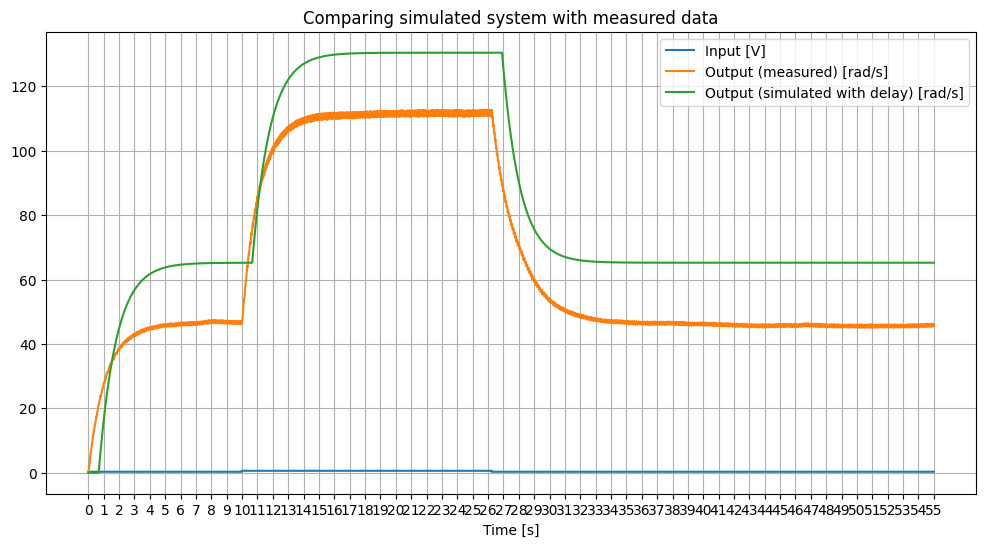

In [4]:
################################################################################

# Apply time lag by shifting and zeroing before lag
shift_samples = int(time_lag / (t[1] - t[0]))  # convert seconds to samples
output_sim_lagged = np.zeros_like(output_sim)  # start with zeros
if shift_samples < len(output_sim):
    output_sim_lagged[shift_samples:] = output_sim[:-shift_samples]

# y += 0                            # Add an offset to the output response, in case i need it
# input_signal_sim += 0             # Add an offset to the input signal, in case i need it

# Plot the output response
plt.figure()
plt.figure(figsize=(12, 6))
plt.plot(t, input_signal, label=r'Input [V]')
plt.plot(t, output_signal, label=r'Output (measured) [rad/s]')
plt.plot(t, output_sim_lagged, label=r'Output (simulated with delay) [rad/s]')

plt.title("Comparing simulated system with measured data")
plt.xlabel("Time [s]")
plt.xticks(np.arange(0, 56, 1)) # Set x-axis ticks every 1 second
plt.grid(True)
plt.legend()
plt.show()

the lag doesn't seem to fit well, let's zoom in.

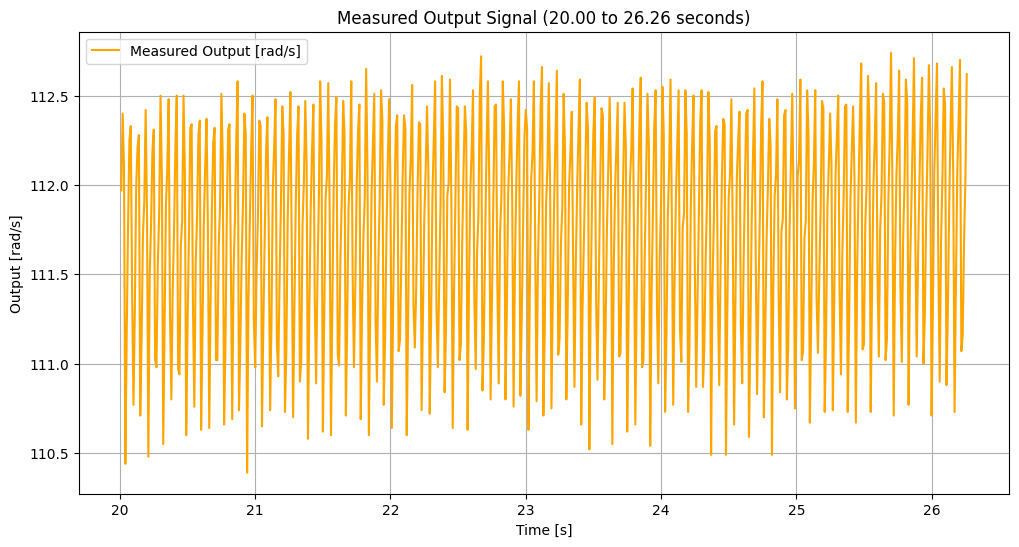

In [5]:
# Plot a portion of the measured output signal
plt.figure(figsize=(12, 6))
plt.plot(time_step[2000:2626], output_signal[2000:2626], label='Measured Output [rad/s]', color='orange')
plt.title('Measured Output Signal (20.00 to 26.26 seconds)')
plt.xlabel('Time [s]')
plt.ylabel('Output [rad/s]')
plt.legend()
plt.grid(True)
plt.show()

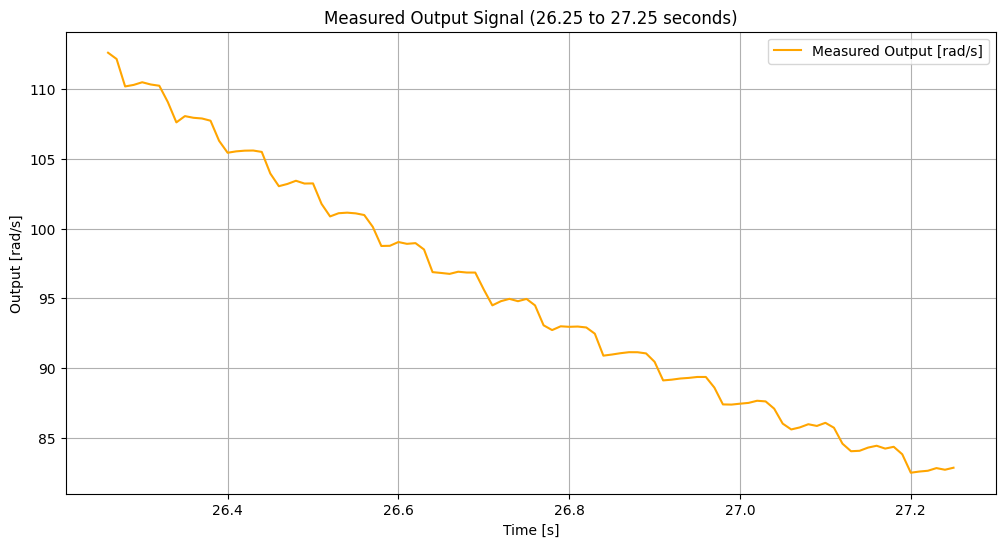

In [6]:
# Plot a portion of the measured output signal
plt.figure(figsize=(12, 6))
plt.plot(time_step[2625:2725], output_signal[2625:2725], label='Measured Output [rad/s]', color='orange')
plt.title('Measured Output Signal (26.25 to 27.25 seconds)')
plt.xlabel('Time [s]')
plt.ylabel('Output [rad/s]')
plt.legend()
plt.grid(True)
plt.show()

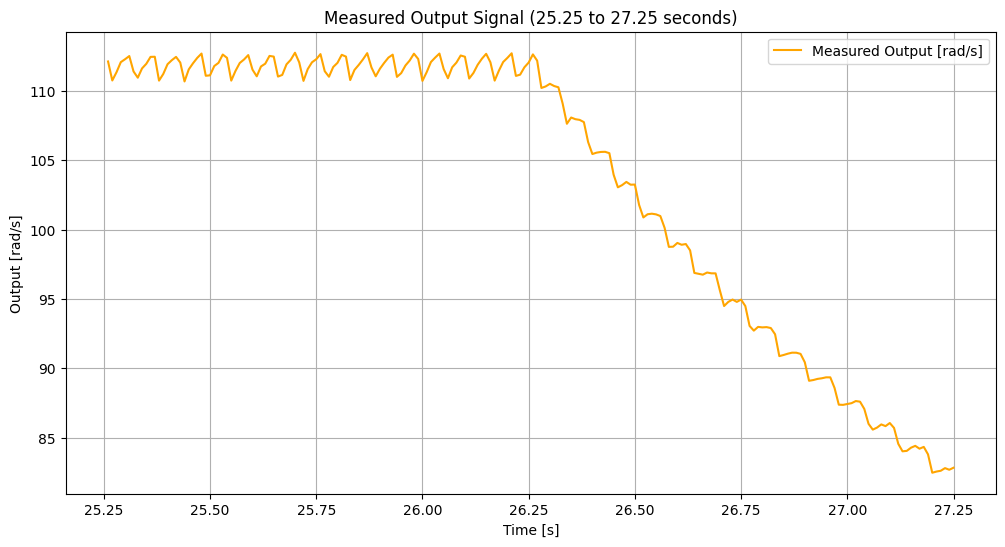

In [7]:
# Plot a portion of the measured output signal
plt.figure(figsize=(12, 6))
plt.plot(time_step[2525:2725], output_signal[2525:2725], label='Measured Output [rad/s]', color='orange')
plt.title('Measured Output Signal (25.25 to 27.25 seconds)')
plt.xlabel('Time [s]')
plt.ylabel('Output [rad/s]')
plt.legend()
plt.grid(True)
plt.show()

Let's delete th lag.

<Figure size 640x480 with 0 Axes>

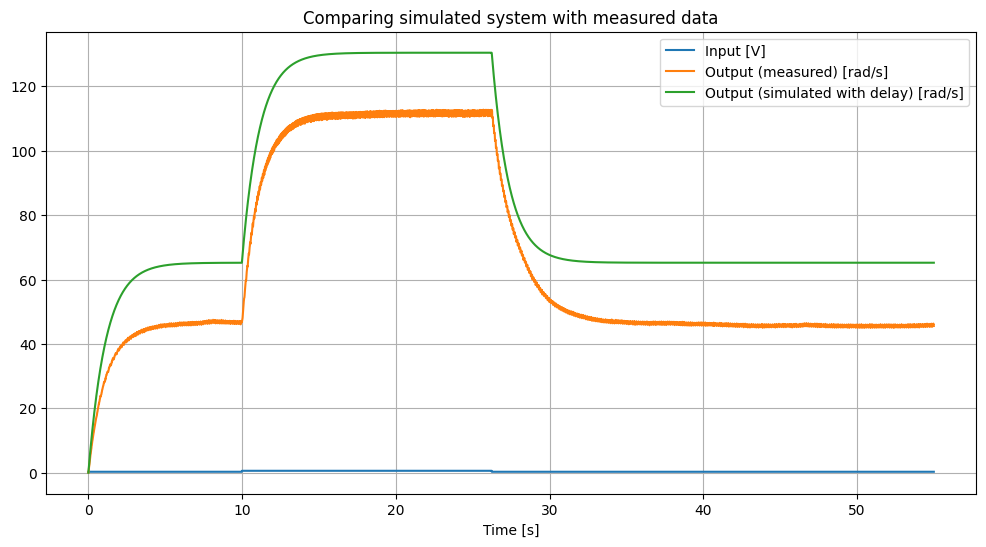

In [8]:
# y += 0                            # Add an offset to the output response, in case i need it
# input_signal_sim += 0             # Add an offset to the input signal, in case i need it

# Plot the output response
plt.figure()
plt.figure(figsize=(12, 6))
plt.plot(t, input_signal, label=r'Input [V]')
plt.plot(t, output_signal, label=r'Output (measured) [rad/s]')
plt.plot(t, output_sim, label=r'Output (simulated with delay) [rad/s]')

plt.title("Comparing simulated system with measured data")
plt.xlabel("Time [s]")
plt.grid(True)
plt.legend()
plt.show()

# Bode

Magnitu & phase diagrams.

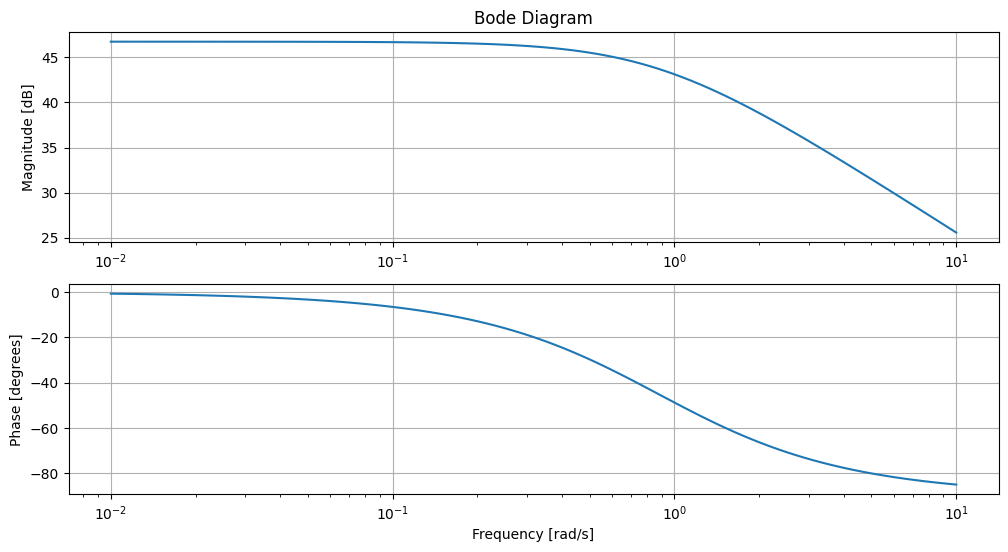

In [9]:
# Bode Diagram of the transfer function
from scipy import signal

# Create the frequency response
w, mag, phase = signal.bode(system1)

# Plot the Bode diagram
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.semilogx(w, mag)  # Bode magnitude plot
plt.title('Bode Diagram')
plt.ylabel('Magnitude [dB]')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.semilogx(w, phase)  # Bode phase plot
plt.xlabel('Frequency [rad/s]')
plt.ylabel('Phase [degrees]')
plt.grid(True)

plt.show()

# FREQUENCY RESPONSE

Hereafter we are going to draw the empirical data we have.

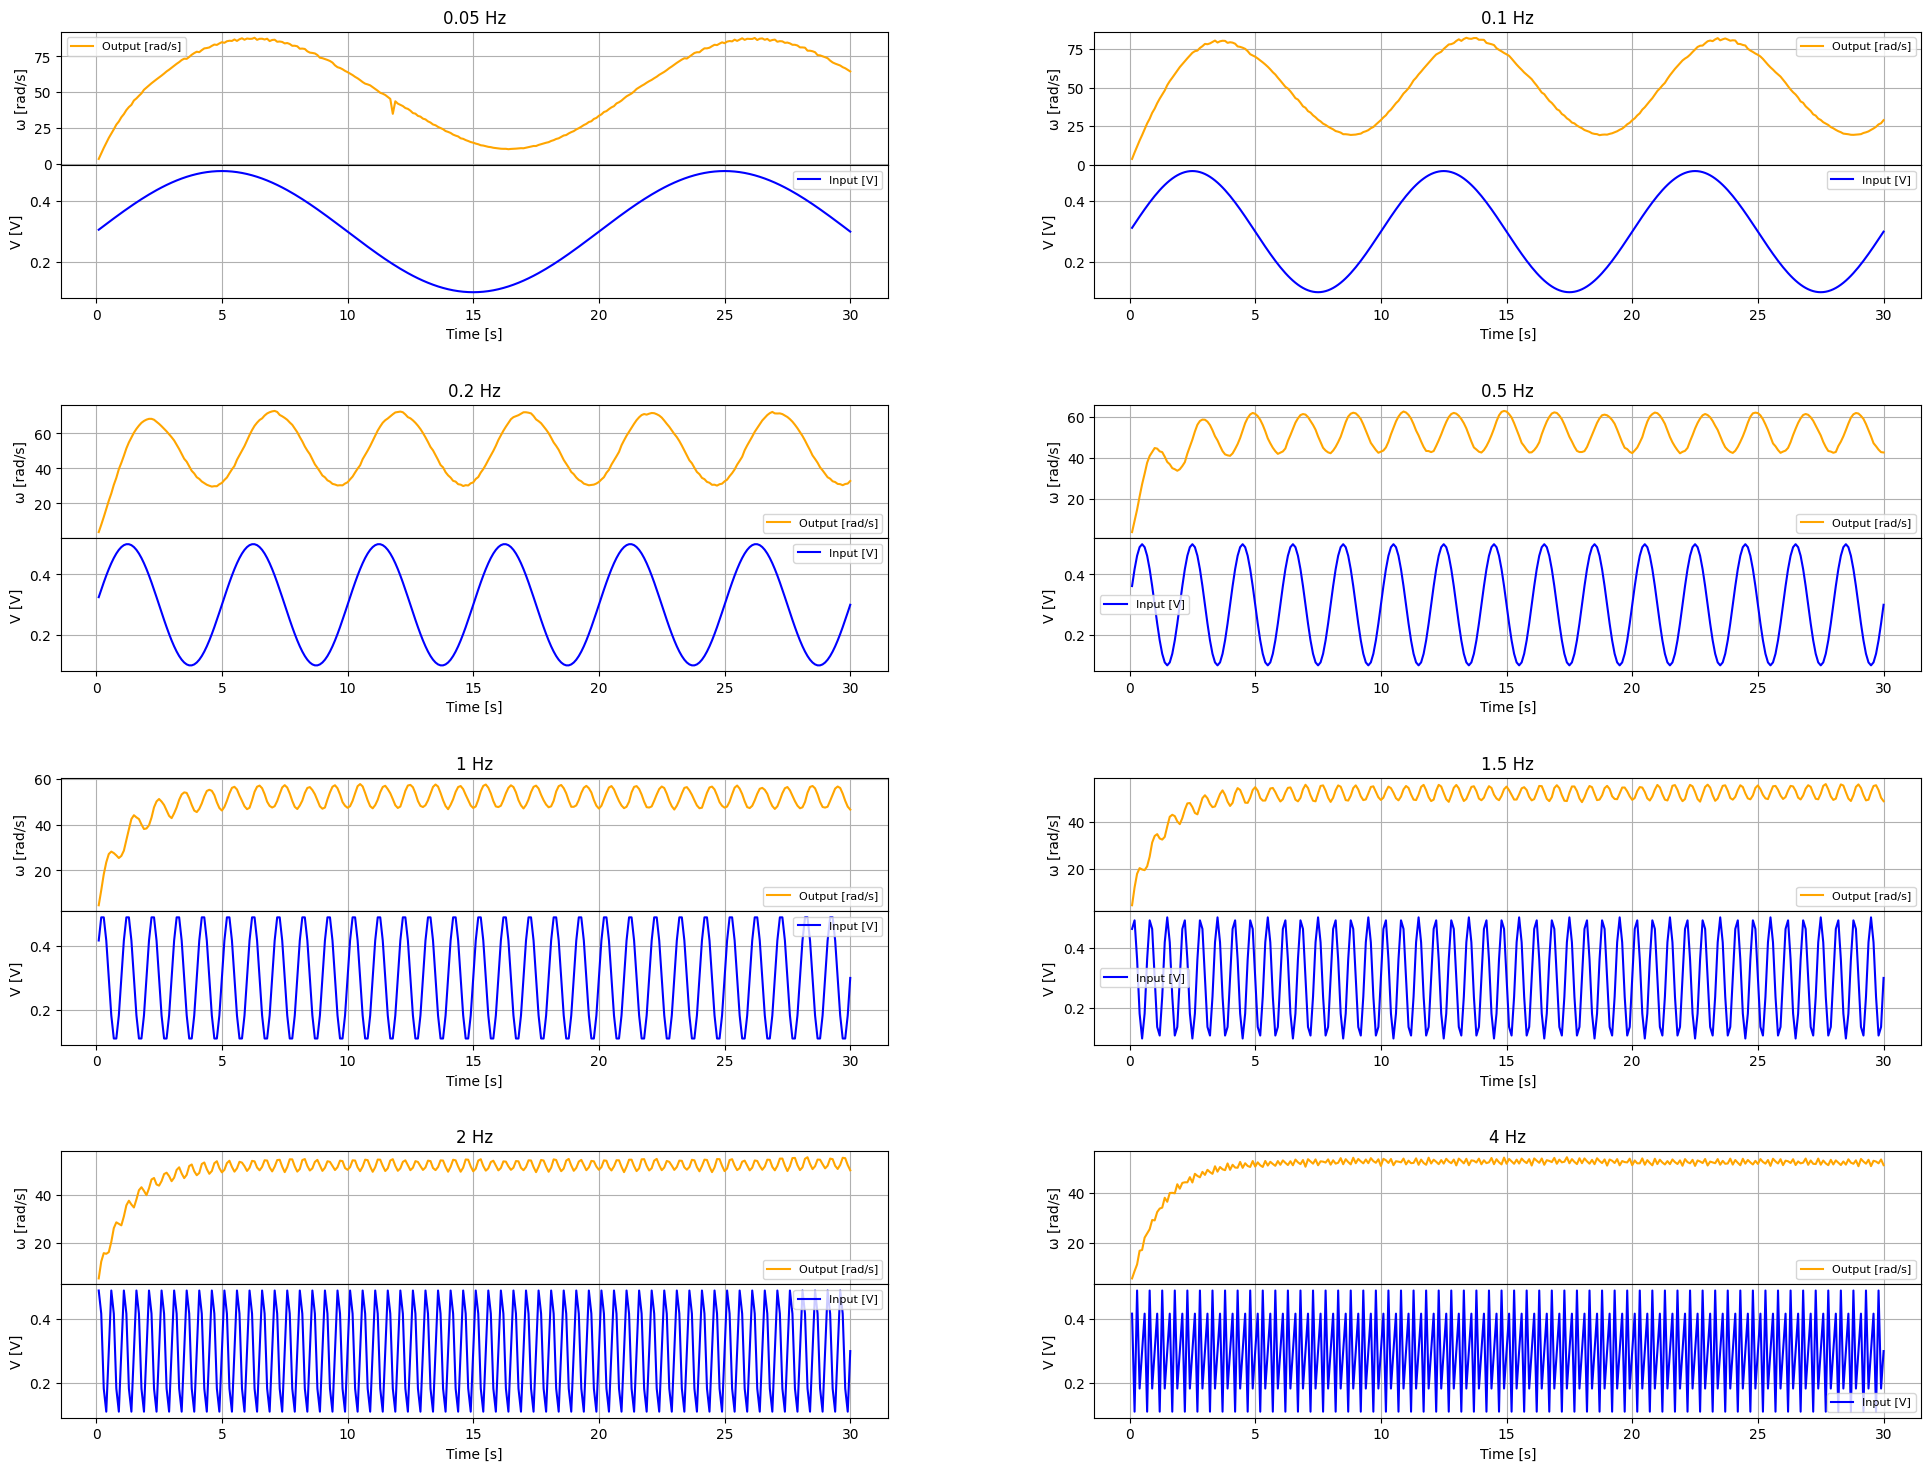

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Load frequency response data
csv_file_name_2 = 'FreqResponse.csv'
freq_data = pd.read_csv(csv_file_name_2)
frequencies = [0.05, 0.1, 0.2, 0.5, 1, 1.5, 2, 4]    # [Hz]

# Data
freq_data_plot = freq_data.values
time = freq_data_plot[:, 0]

# Create main figure with 4x2 layout
fig = plt.figure(figsize=(24, 18))
outer_gs = gridspec.GridSpec(4, 2, wspace=0.25, hspace=0.4)  # spacing between panels

for idx, freq in enumerate(frequencies):
    row = idx // 2
    col = idx % 2

    # Create inner grid (2 rows, 1 column) for output and input stacked
    inner_gs = gridspec.GridSpecFromSubplotSpec(
        2, 1, subplot_spec=outer_gs[row, col], hspace=0
    )

    # Output plot (top)
    ax_out = fig.add_subplot(inner_gs[0])
    ax_out.plot(time, freq_data_plot[:, idx + 9], color='orange', label='Output [rad/s]')
    ax_out.set_title(f'{freq} Hz')
    ax_out.set_ylabel('ω [rad/s]')
    ax_out.legend(fontsize=8)
    ax_out.grid(True)
    ax_out.tick_params(labelbottom=False)  # hide x-axis labels for top plot

    # Input plot (bottom)
    ax_in = fig.add_subplot(inner_gs[1], sharex=ax_out)
    ax_in.plot(time, freq_data_plot[:, idx + 1], color='blue', label='Input [V]')
    ax_in.set_ylabel('V [V]')
    ax_in.set_xlabel('Time [s]')
    ax_in.legend(fontsize=8)
    ax_in.grid(True)

plt.show()

Model vs Empirical Bode.

   Frequncies [Hz]  Empirical Gain [rad / V s]
0             0.05                  194.040000
1             0.10                  157.647500
2             0.20                  106.460097
3             0.50                   51.315000
4             1.00                   29.441144
5             1.50                   19.060000
6             2.00                   16.145313
7             4.00                    9.373850


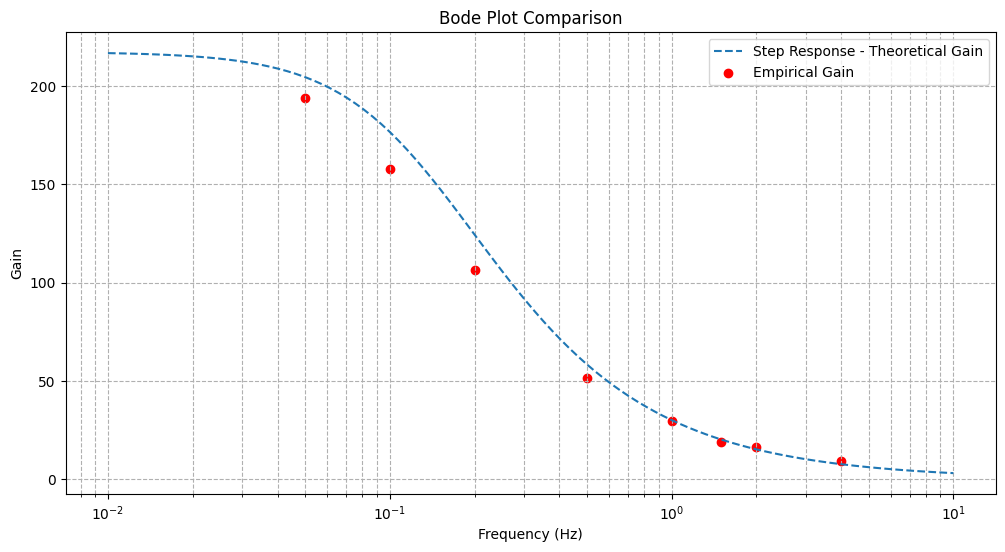

In [11]:
# Calculate empirical gains
gain_measured = []
for i in range(8):
    input_signal_freq = freq_data.iloc[:, 1 + i]
    output_signal_freq = freq_data.iloc[:, 9 + i]
    gain = (np.max(output_signal_freq[75:])-np.min(output_signal_freq[75:])) / (np.max(input_signal_freq[75:])-np.min(input_signal_freq[75:]))
    gain_measured.append(gain)

table = pd.DataFrame({
    'Frequncies [Hz]': frequencies,
    'Empirical Gain [rad / V s]': gain_measured,
})
print(table)

# Frequencies for Bode plot (in Hz)
frequencies_theoretical = np.logspace(-2, 1, 100)          # Frequencies from 0.01 Hz to 10 Hz
# Adding "frequencies" vector to "frequencies_theoretical" vector for later. Combine, remove duplicates, and sort.
frequencies_theoretical = np.unique(np.concatenate((frequencies_theoretical, frequencies)))
omega_theoretical = 2 * np.pi * frequencies_theoretical    # Convertin Frequencies [Hz] to Angular frequencies [rad/s]
# Compute the gain for each frequency
gain_theoretical = K / np.sqrt(1 + (omega_theoretical * tau) ** 2)

# Plot Bode plots
plt.figure(figsize=(12, 6))
plt.plot(frequencies_theoretical, gain_theoretical, label='Step Response - Theoretical Gain', linestyle='--')
plt.scatter(frequencies, gain_measured, color='red', label='Empirical Gain')
plt.xscale('log')
plt.yscale('linear')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Bode Plot Comparison')
plt.legend()
plt.grid(which='both', linestyle='--')
plt.show()

# Manual tuning of K and T for better fit (if required)

Let's fine tune the process parameters (time constant, static gain) to make
the theoretical frequency response fit the empirically measured.

Minimum RMSD: 2.833820


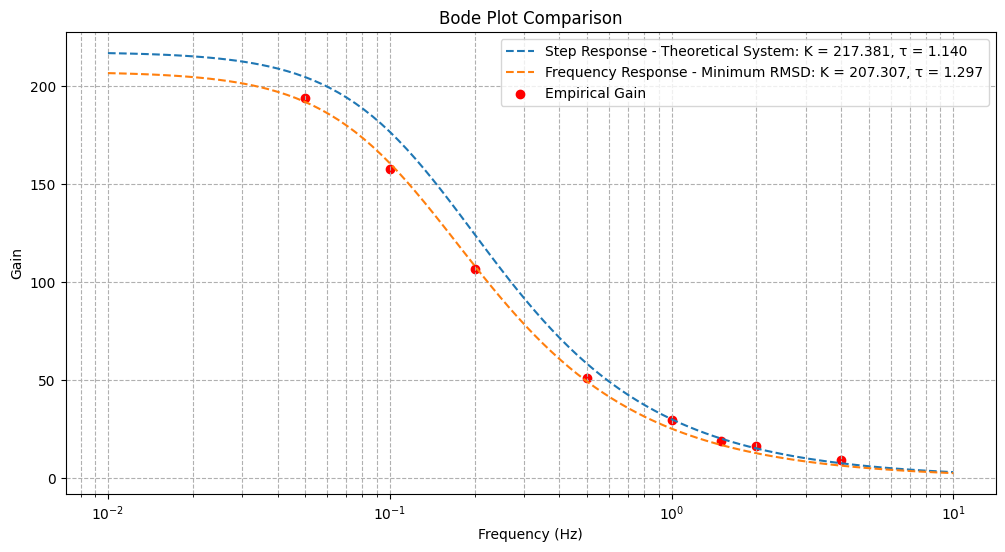

In [12]:
frequencies_array = np.array(frequencies, dtype=float)                          # Convert to NumPy array of floats
K_test = np.linspace(180,260,1000)                                              # setting the values for K
tau_test = np.linspace(1,2.5,1000)                                              # setting the values for tau
rmsd_matrix = np.zeros((len(K_test), len(tau_test)))                            # create a matrix with K rows and tau columns
for i_idx, i in enumerate(K_test):                                              # Computing the matrix of root mean square deviations for K and tau
  for j_idx, j in enumerate(tau_test):
    omega_test = 2 * np.pi * frequencies_array
    gain_theoretical_test = i / np.sqrt(1 + (omega_test * j) ** 2)
    rmsd = np.sqrt(np.mean((gain_theoretical_test - gain_measured) ** 2))       # root mean square deviation
    rmsd_matrix[i_idx, j_idx] = rmsd

# finding the minimum indexes of the matrix
rmsd_min = np.min(rmsd_matrix)
rmsd_index_min = np.unravel_index(np.argmin(rmsd_matrix), rmsd_matrix.shape)
K_refined = K_test[rmsd_index_min[0]]
tau_refined = tau_test[rmsd_index_min[1]]
gain_refined = K_refined / np.sqrt(1 + (omega_theoretical * tau_refined) ** 2)

print(f"Minimum RMSD: {rmsd_min:.6f}")

# Plot Bode plots
plt.figure(figsize=(12, 6))
plt.plot(frequencies_theoretical, gain_theoretical, label='Step Response - Theoretical System: K = 217.381, τ = 1.140', linestyle='--')
plt.plot(frequencies_theoretical, gain_refined, label=f'Frequency Response - Minimum RMSD: K = {K_refined:.3f}, τ = {tau_refined:.3f}', linestyle='--')
plt.scatter(frequencies, gain_measured, color='red', label='Empirical Gain')
plt.xscale('log')
plt.yscale('linear')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Bode Plot Comparison')
plt.legend()
plt.grid(which='both', linestyle='--')
plt.show()

# Manual tuning of K and T for better fit (if required)

Let's draw the plot for the new K and tau.

<Figure size 640x480 with 0 Axes>

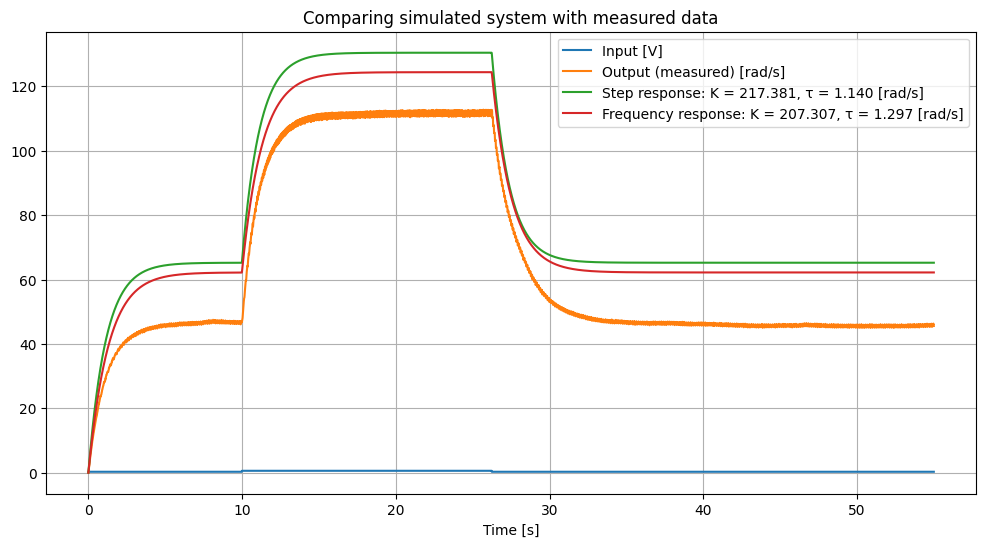

In [13]:
numerator_refined = [K_refined]
denominator_refined = [tau_refined, 1]
system_refined = TransferFunction(numerator_refined, denominator_refined)
t = np.linspace(0, 55, 5500)
t, output_refined, _ = lsim(system_refined, input_signal, t)

# Plot the output response
plt.figure()
plt.figure(figsize=(12, 6))
plt.plot(t, input_signal, label='Input [V]')
plt.plot(t, output_signal, label='Output (measured) [rad/s]')
plt.plot(t, output_sim, label=f'Step response: K = {K:.3f}, τ = {tau:.3f} [rad/s]')
plt.plot(t, output_refined, label=f'Frequency response: K = {K_refined:.3f}, τ = {tau_refined:.3f} [rad/s]')
plt.title("Comparing simulated system with measured data")
plt.xlabel("Time [s]")
plt.grid(True)
plt.legend()
plt.show()

# OVERDAMPED SECOND ORDER

In [14]:
%%capture
%reset -f

loading

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import TransferFunction, lti, step, bode, lsim

# Load step response data
from google.colab import drive
drive.mount('/content/drive')
import os
google_drive_root = '/content/drive/MyDrive'
assignment2_loc = '/Novia/Dynamical Systems/Datamaterial for assignment 2-20241124'
os.chdir(google_drive_root + assignment2_loc)
csv_file_name = 'StepData.csv'
step_data = pd.read_csv(csv_file_name)

time_step = step_data.iloc[:, 0]         # time vector computed in seconds [s]
input_signal = step_data.iloc[:, 1]      # Input vector in Volts [V]
output_signal = step_data.iloc[:, 2]     # Output vector in meters per seconds [rad/s]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


cleaning the noise

In [16]:
# The signal contains some noise in the first transient. Let's clean it.
output_signal[5010] = output_signal[5009]
output_signal[5011] = output_signal[5012]

static gain K

In [17]:
# Mean value of the input & output from seconds 9.5 to 10 and from second 25.74 to 26.24
mean_initial_input = input_signal.iloc[947:997].values
mean_initial_output = output_signal.iloc[947:997].values
mean_final_input = input_signal.iloc[2572:2622].values
mean_final_output = output_signal.iloc[2572:2622].values

# Calculate the mean value
mean_initial_input = mean_initial_input.mean()
#print("Mean value of the initial input:", mean_initial_input)         # for debugging
mean_initial_output = mean_initial_output.mean()
#print("Mean value of the initial output:", mean_initial_output)       # for debugging
mean_final_input = mean_final_input.mean()
#print("Mean value of the final input:", mean_final_input)             # for debugging
mean_final_output = mean_final_output.mean()
#print("Mean value of the final output:", mean_final_output)           # for debugging

# Static gain K
delta_in  = mean_final_input - mean_initial_input
delta_out = mean_final_output - mean_initial_output
K = delta_out / delta_in
K_model = K
K_formatted = "{:.3f}".format(K)
print(f"Estimated static gain (K): {K_formatted}")

Estimated static gain (K): 217.381


fitting the exponential model

In [18]:
import numpy as np
from scipy.optimize import curve_fit

# --- 1) Fixed fitting range ---
idx_start = 970
idx_end = 2550

t_win = time_step[idx_start:idx_end] - time_step[idx_start]
y_win = output_signal[idx_start:idx_end] - output_signal[idx_start]

# Step amplitude in this range
du = input_signal[idx_start:idx_end].max() - input_signal[idx_start:idx_end].min()
y_inf = K * du  # steady-state change expected

# --- 2) Overdamped step model with stable poles ---
def step_overdamped(t, s1, s2):
    p1 = -np.exp(s1)   # forces p1 < 0
    p2 = -np.exp(s2)   # forces p2 < 0
    if np.isclose(p1, p2):
        p2 *= 1.001
    g = 1.0 - (p2*np.exp(p1*t) - p1*np.exp(p2*t)) / (p2 - p1)
    return y_inf * g  # baseline already removed

# --- 3) Initial guesses for poles ---
s1_0 = np.log(1.0)    # fast pole
s2_0 = np.log(0.1)    # slow pole

# --- 4) Fit the model ---
popt, pcov = curve_fit(step_overdamped, t_win, y_win, p0=[s1_0, s2_0])
s1, s2 = popt
p1, p2 = -np.exp(s1), -np.exp(s2)

# Sort so |p1| >= |p2|
if abs(p1) < abs(p2):
    p1, p2 = p2, p1

# --- 5) Compute omega_n and zeta ---
omega_n = np.sqrt(p1 * p2)
zeta = -(p1 + p2) / (2.0 * omega_n)

# --- 6) Coefficients A,B for sum-of-exponentials form ---
A = -p2 / (p2 - p1)
B =  p1 / (p2 - p1)

print(f"omega_n = {omega_n:.6f}")
print(f"zeta = {zeta:.6f}")
print(f"A = {A:.6f}, B = {B:.6f}, lambda1 = {p1:.6f}, lambda2 = {p2:.6f}")

omega_n = 1.709783
zeta = 1.238803
A = 0.347119, B = -1.347119, lambda1 = -3.368253, lambda2 = -0.867915


transfer function implementation and plot

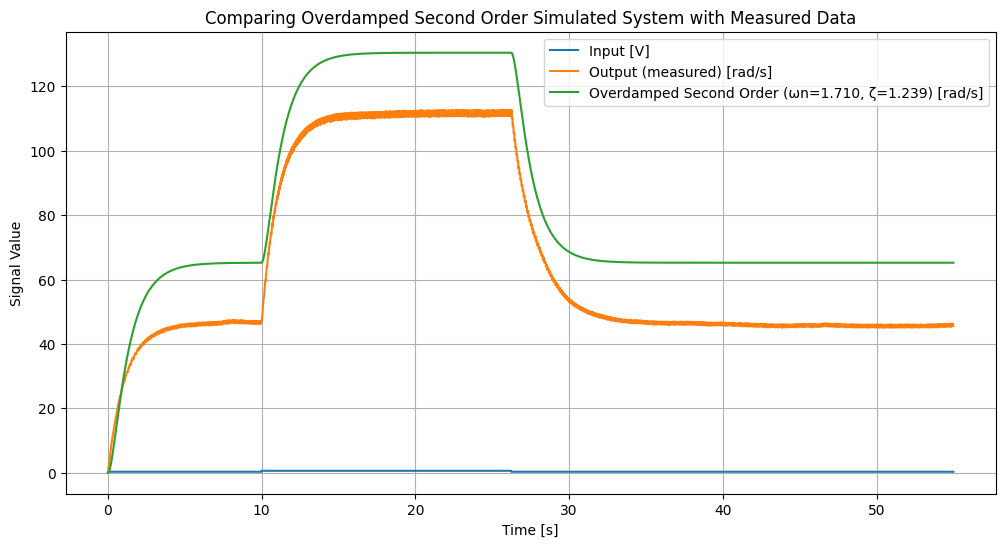

In [19]:
# --- 7) Define the transfer function ---
# The transfer function for an overdamped second-order system is given by:
# G(s) = K * omega_n^2 / (s^2 + 2*zeta*omega_n*s + omega_n^2)
# Or, in terms of the poles p1 and p2:
# G(s) = K * (p1 * p2) / ((s - p1) * (s - p2))

# Using the calculated omega_n and zeta
numerator_overdamped = [K * omega_n**2]
denominator_overdamped = [1, 2 * zeta * omega_n, omega_n**2]
system_overdamped = TransferFunction(numerator_overdamped, denominator_overdamped)

# --- 8) Simulate the step response ---
# Generate time points
t = np.linspace(0, 55, 5500)

# Calculate the system's output using lsim (for custom input)
t, output_overdamped, _ = lsim(system_overdamped, input_signal, t)

# --- 9) Plot the results ---
plt.figure(figsize=(12, 6))
plt.plot(t, input_signal, label='Input [V]')
plt.plot(t, output_signal, label='Output (measured) [rad/s]')
plt.plot(t, output_overdamped, label=f'Overdamped Second Order (ωn={omega_n:.3f}, ζ={zeta:.3f}) [rad/s]')

plt.title("Comparing Overdamped Second Order Simulated System with Measured Data")
plt.xlabel("Time [s]")
plt.ylabel("Signal Value")
plt.grid(True)
plt.legend()
plt.show()

Bode

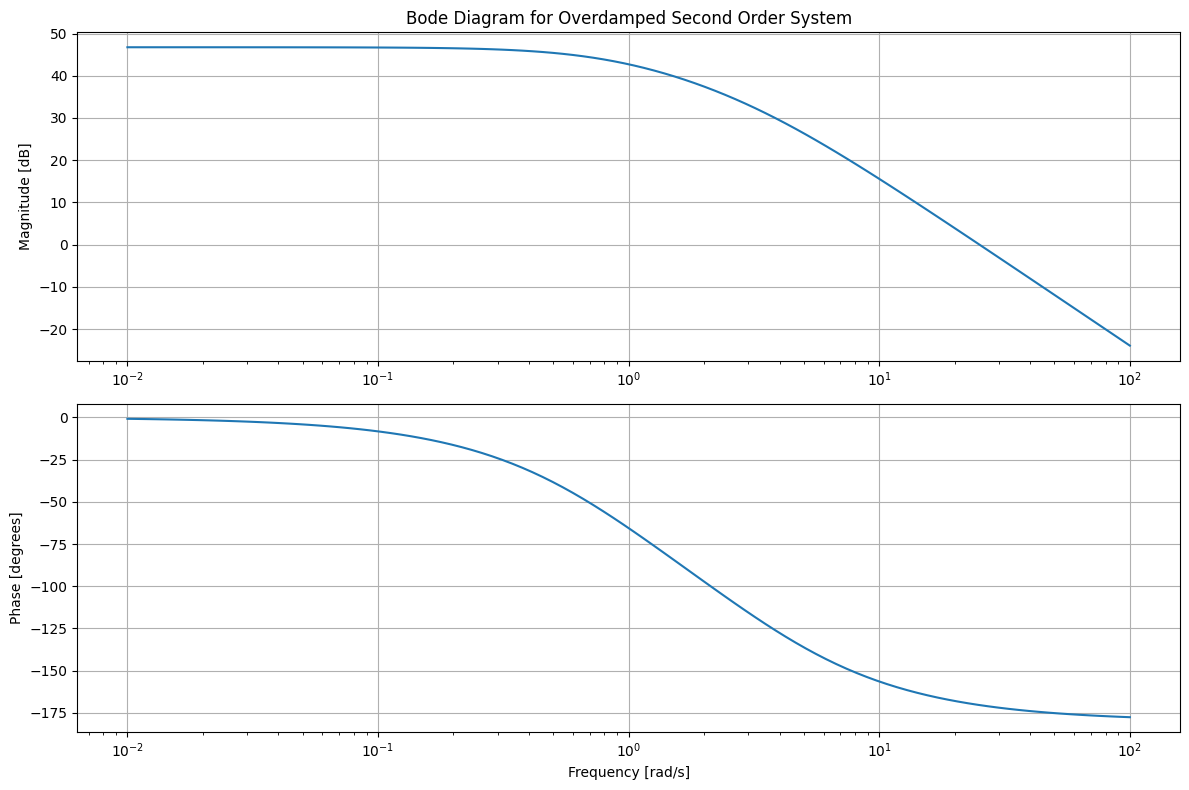

In [20]:
# Bode Diagram of the overdamped second-order transfer function
from scipy import signal

# Create the frequency response
w_overdamped, mag_overdamped, phase_overdamped = signal.bode(system_overdamped)

# Plot the Bode diagram
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.semilogx(w_overdamped, mag_overdamped)  # Bode magnitude plot
plt.title('Bode Diagram for Overdamped Second Order System')
plt.ylabel('Magnitude [dB]')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.semilogx(w_overdamped, phase_overdamped)  # Bode phase plot
plt.xlabel('Frequency [rad/s]')
plt.ylabel('Phase [degrees]')
plt.grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

Frequency Response

   Frequncies [Hz]  Empirical Gain [rad / V s]
0             0.05                  194.040000
1             0.10                  157.647500
2             0.20                  106.460097
3             0.50                   51.315000
4             1.00                   29.441144
5             1.50                   19.060000
6             2.00                   16.145313
7             4.00                    9.373850


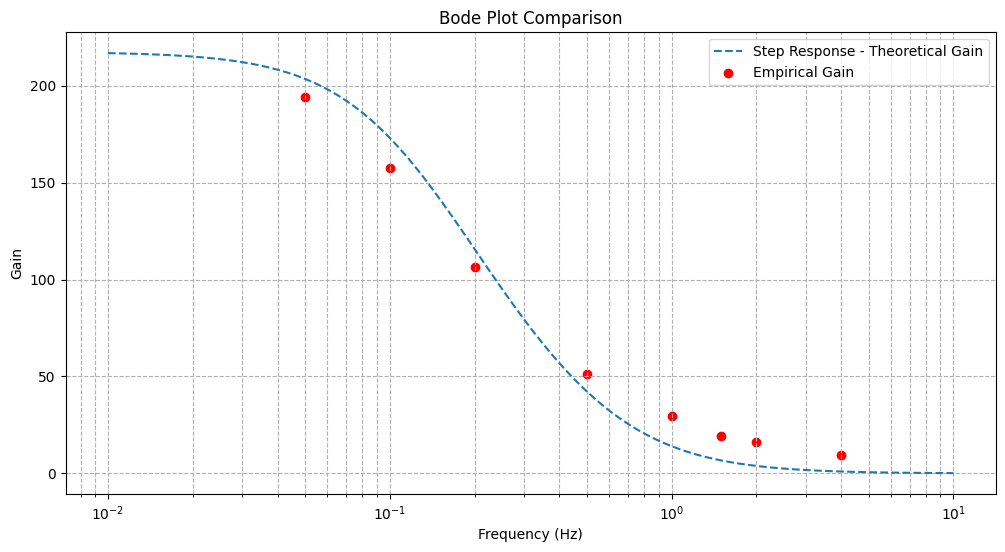

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Load frequency response data
csv_file_name_2 = 'FreqResponse.csv'
freq_data = pd.read_csv(csv_file_name_2)
frequencies = [0.05, 0.1, 0.2, 0.5, 1, 1.5, 2, 4]    # [Hz]

# Data
freq_data_plot = freq_data.values
time = freq_data_plot[:, 0]

################################################################################

# Calculate empirical gains
gain_measured = []
for i in range(8):
    input_signal_freq = freq_data.iloc[:, 1 + i]
    output_signal_freq = freq_data.iloc[:, 9 + i]
    gain = (np.max(output_signal_freq[75:])-np.min(output_signal_freq[75:])) / (np.max(input_signal_freq[75:])-np.min(input_signal_freq[75:]))
    gain_measured.append(gain)

table = pd.DataFrame({
    'Frequncies [Hz]': frequencies,
    'Empirical Gain [rad / V s]': gain_measured,
})
print(table)

# Frequencies for Bode plot (in Hz)
frequencies_theoretical = np.logspace(-2, 1, 100)          # Frequencies from 0.01 Hz to 10 Hz
# Adding "frequencies" vector to "frequencies_theoretical" vector for later. Combine, remove duplicates, and sort.
frequencies_theoretical = np.unique(np.concatenate((frequencies_theoretical, frequencies)))
omega_theoretical = 2 * np.pi * frequencies_theoretical    # Convertin Frequencies [Hz] to Angular frequencies [rad/s]
# Compute the gain for each frequency
gain_theoretical = (K * omega_n**2) / np.sqrt(
    (omega_n**2 - omega_theoretical**2)**2 +
    (2 * zeta * omega_n * omega_theoretical)**2
)

# Plot Bode plots
plt.figure(figsize=(12, 6))
plt.plot(frequencies_theoretical, gain_theoretical, label='Step Response - Theoretical Gain', linestyle='--')
plt.scatter(frequencies, gain_measured, color='red', label='Empirical Gain')
plt.xscale('log')
plt.yscale('linear')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Bode Plot Comparison')
plt.legend()
plt.grid(which='both', linestyle='--')
plt.show()

# Manual tuning of K and T for better fit (if required)

Best fit parameters: K = 207.474747, ωn = 7.500000, ζ = 4.919192
Minimum RMSD: 2.942783817064218


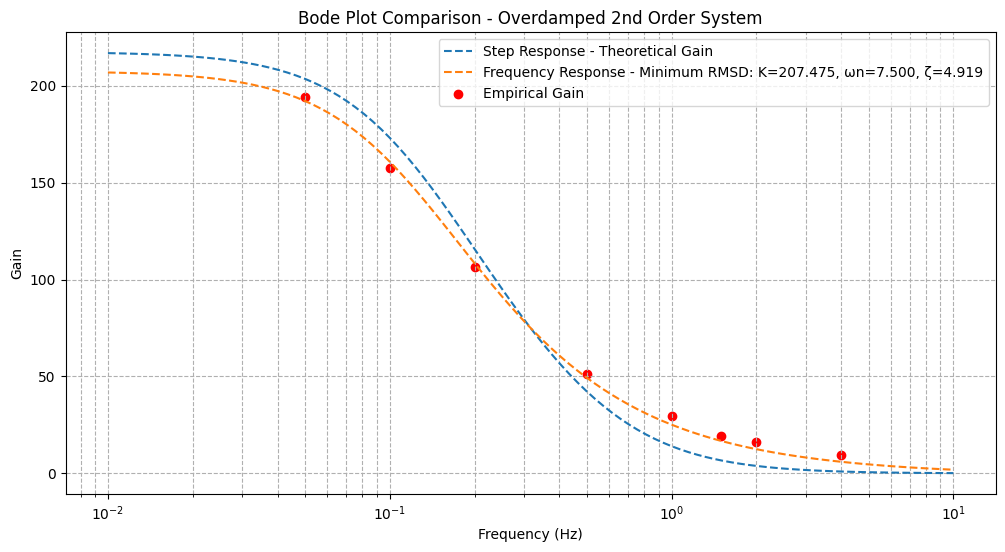

In [22]:
# --- Prepare test ranges ---
frequencies_array = np.array(frequencies, dtype=float)  # Convert to NumPy array
K_test = np.linspace(180, 260, 100)                     # K range
omega_n_test = np.linspace(0.3, 30, 100)                   # ωn range
zeta_test = np.linspace(1, 5, 100)                      # ζ range

# Create 3D RMSD matrix (K × ωn × ζ)
rmsd_matrix = np.zeros((len(K_test), len(omega_n_test), len(zeta_test)))

# --- Triple loop search ---
for i_idx, K_val in enumerate(K_test):
    for j_idx, omega_n_val in enumerate(omega_n_test):
        for k_idx, zeta_val in enumerate(zeta_test):

            omega_array = 2 * np.pi * frequencies_array

            # Second-order magnitude formula
            gain_theoretical_test = (K_val * omega_n_val**2) / np.sqrt(
                (omega_n_val**2 - omega_array**2)**2 +
                (2 * zeta_val * omega_n_val * omega_array)**2
            )

            # RMSD calculation
            rmsd = np.sqrt(np.mean((gain_theoretical_test - gain_measured) ** 2))
            rmsd_matrix[i_idx, j_idx, k_idx] = rmsd

# --- Find best parameters ---
rmsd_min = np.min(rmsd_matrix)
best_idx = np.unravel_index(np.argmin(rmsd_matrix), rmsd_matrix.shape)
K_refined = K_test[best_idx[0]]
omega_n_refined = omega_n_test[best_idx[1]]
zeta_refined = zeta_test[best_idx[2]]

print(f"Best fit parameters: K = {K_refined:.6f}, ωn = {omega_n_refined:.6f}, ζ = {zeta_refined:.6f}")
print(f"Minimum RMSD: {rmsd_min}")

# --- Compute refined gain curve ---
gain_refined = (K_refined * omega_n_refined**2) / np.sqrt(
    (omega_n_refined**2 - omega_theoretical**2)**2 +
    (2 * zeta_refined * omega_n_refined * omega_theoretical)**2
)

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(frequencies_theoretical, gain_theoretical, label='Step Response - Theoretical Gain', linestyle='--')
plt.plot(frequencies_theoretical, gain_refined,
         label=f'Frequency Response - Minimum RMSD: K={K_refined:.3f}, ωn={omega_n_refined:.3f}, ζ={zeta_refined:.3f}',
         linestyle='--')
plt.scatter(frequencies, gain_measured, color='red', label='Empirical Gain')
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.title('Bode Plot Comparison - Overdamped 2nd Order System')
plt.legend()
plt.grid(which='both', linestyle='--')
plt.show()

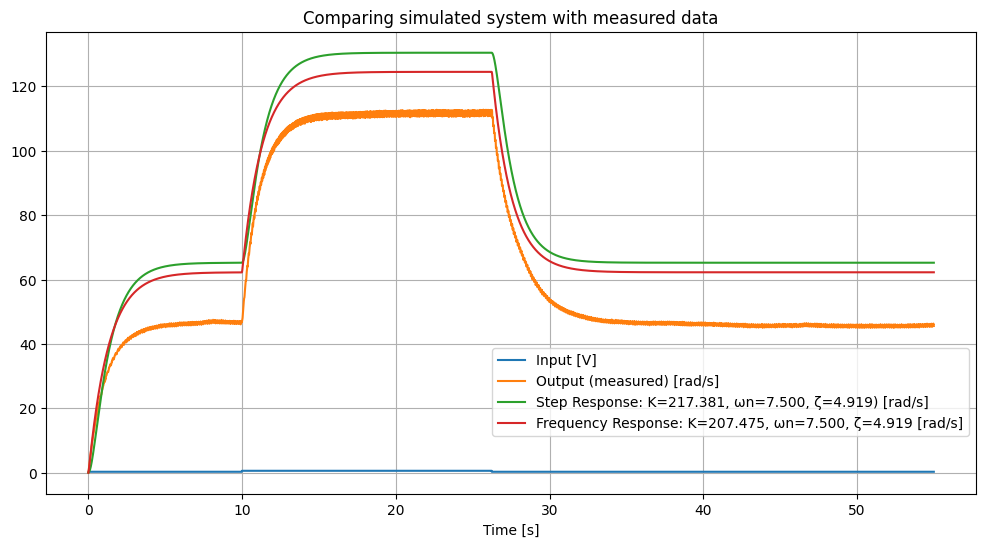

In [23]:
from scipy.signal import TransferFunction, lsim
import numpy as np
import matplotlib.pyplot as plt

# Second-order parameters
K = 207.474747
omega_n = 7.5
zeta = 4.919192

# Transfer function coefficients
numerator_second = [K * omega_n**2]
denominator_second = [1, 2 * zeta * omega_n, omega_n**2]

# Create system
system_second = TransferFunction(numerator_second, denominator_second)

# Time vector
t = np.linspace(0, 55, 5500)

# Simulate response to input signal
t, output_second_frequency, _ = lsim(system_second, input_signal, t)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(t, input_signal, label='Input [V]')
plt.plot(t, output_signal, label='Output (measured) [rad/s]')
plt.plot(t, output_overdamped, label=f'Step Response: K={K_model:.3f}, ωn={omega_n:.3f}, ζ={zeta:.3f}) [rad/s]')
plt.plot(t, output_second_frequency, label=f'Frequency Response: K={K:.3f}, ωn={omega_n:.3f}, ζ={zeta:.3f} [rad/s]')
plt.title("Comparing simulated system with measured data")
plt.xlabel("Time [s]")
plt.grid(True)
plt.legend()
plt.legend(loc="lower right", bbox_to_anchor=(1, 0.11))
plt.show()